In [1]:
# This notebook checks MNE functions for ECG and EOG detection
# Cropped data is used here (5 minutes only), tried on whole data - takes forever.


#Load data, make folders
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import configparser
import ancpbids

from main_meg_qc import make_derivative_meg_qc, sanity_check, initial_stuff
from RMSE_meq_qc import RMSE_meg_qc
from PSD_meg_qc import PSD_meg_qc
from Peaks_auto_meg_qc import PP_auto_meg_qc


Opening raw data file /Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif...
    Range : 60000 ... 1255999 =     60.000 ...  1255.999 secs
Ready.
Stimulus channels detected: ['STI101', 'STI201', 'STI301']
9 events found
Event IDs: [2 4 8]
Trigger channel has a non-zero initial value of 3840 (consider using initial_event=True to detect this event)
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Loading data for 9 events and 1201 original time points ...
0 bad epochs dropped
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Loading data for 9 events and 1201 original time points ...
0 bad epochs dropped
ECG channel used to identify hearbeats:  ECG062
Average pulse:  76  per minute
Using channel ECG062 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
--------------------

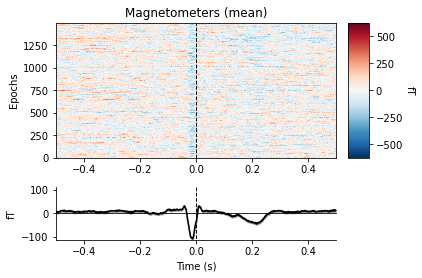

Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


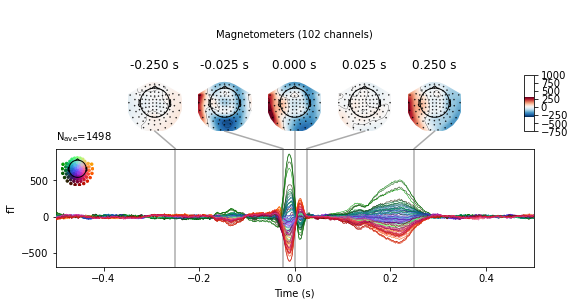

Not setting metadata
1498 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


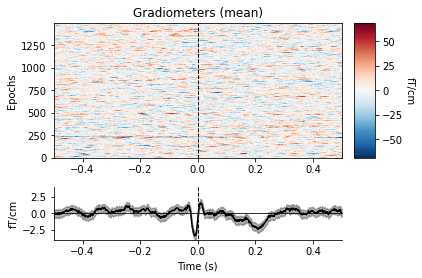

Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


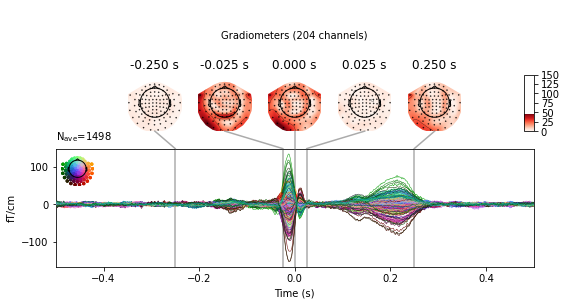

mean_ECG_epoch_mags
Figure(432x288)


/Users/jenya/opt/anaconda3/envs/mne_new/lib/python3.9/site-packages/mpld3/mplexporter/exporter.py:84: UserWarning: Blended transforms not yet supported. Zoom behavior may not work as expected.
  warnings.warn("Blended transforms not yet supported. "


mean_ECG_epoch_grads
Figure(432x288)
ECG_field_pattern_sensors_mags
Figure(576x302.4)
ECG_field_pattern_sensors_grads
Figure(576x302.4)


NameError: name 'dfs_ptp_amlitude_annot' is not defined

In [2]:
#%% TRY TO SAVE DERIVATIVE FROM BIDS DATASET HERE:

config_file_name = 'settings.ini'
dfs_ptp_amlitude_annot, bad_channels = make_derivative_meg_qc(config_file_name)


In [7]:
dfs_ptp_amlitude_annot['mags']

,onset,duration,description,ch_names
0,2019-02-21 11:12:50.619717,0.003,BAD_flat,"(MEG0231,)"
1,2019-02-21 11:12:50.620717,0.002,BAD_flat,"(MEG1621,)"
2,2019-02-21 11:12:50.620717,0.003,BAD_flat,"(MEG0621,)"
3,2019-02-21 11:12:50.622717,0.002,BAD_flat,"(MEG0411,)"
4,2019-02-21 11:12:50.626717,0.002,BAD_flat,"(MEG0121,)"
...,...,...,...,...
78,2019-02-21 11:12:50.786717,0.003,BAD_flat,"(MEG1721,)"
79,2019-02-21 11:12:50.826717,0.002,BAD_flat,"(MEG2131,)"
80,2019-02-21 11:12:50.884717,0.002,BAD_flat,"(MEG2641,)"
81,2019-02-21 11:12:50.906717,0.002,BAD_flat,"(MEG1211,)"


In [2]:
# Other useful ancp stuff:

config = configparser.ConfigParser()
config.read('settings.ini')

default_direct = config['DEFAULT']['data_directory']
dataset_path = ancpbids.utils.fetch_dataset(default_direct)

from ancpbids import BIDSLayout
layout = BIDSLayout(dataset_path)

list_of_fifs = layout.get(suffix='meg', extension='.fif', return_type='filename')

list_of_subs = layout.get_subjects()


list_of_entities = layout.get_entities()
print(list_of_entities)

OrderedDict([('sub', {'018', '014', '017', '027', '029', '028', '021', '013', '019', '012', '030', '031', '023', '015', '025', '022', '009', '016', '024', '020', '026'}), ('ses', {'1'}), ('task', {'deduction', 'induction'}), ('run', {'1'}), ('desc', {'epochs'})])


In [2]:
#%% TRY SEPARATE FUNCTIONS HERE

config = configparser.ConfigParser()
config.read('settings.ini')
data_file='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif'
sid='009'

df_epochs, epochs_mg, channels, raw_bandpass, raw_bandpass_resamp, raw_cropped, raw = initial_stuff(config, data_file)
m_or_g_chosen = ['mags', 'grads']

m_or_g_chosen = sanity_check(m_or_g_chosen, channels)

if len(m_or_g_chosen) == 0: 
    raise ValueError('No channels to analyze. Check presence of mags and grads in your data set and parameter do_for in settings.')




Opening raw data file /Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif...
    Range : 60000 ... 1255999 =     60.000 ...  1255.999 secs
Ready.
Stimulus channels detected: ['STI101', 'STI201', 'STI301']
9 events found
Event IDs: [2 4 8]
Trigger channel has a non-zero initial value of 3840 (consider using initial_event=True to detect this event)
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Loading data for 9 events and 1201 original time points ...
0 bad epochs dropped
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Loading data for 9 events and 1201 original time points ...
0 bad epochs dropped


In [3]:
config = configparser.ConfigParser()
config.read(config_file_name)
data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif'
dict_of_dfs_epoch, epochs_mg, channels, raw_bandpass, raw_bandpass_resamp, raw_cropped, raw = initial_stuff(config, data_file)
m_or_g_chosen = ['mags','grads']
sid='009'
dfs_ptp_amlitude_annot, bad_channels, amplit_annot_with_ch_names = PP_auto_meg_qc(sid, config, channels, raw, m_or_g_chosen)
